# Modelling BG

## Model Shapping

In [1]:
# Importing the libraries
import os
import pandas as pd

## Load data

In [2]:
# Load and preprocess the train data 
from pipelines import pipeline

data_file = os.path.join('..', '..', '..', '..', 'data', 'raw', 'train.csv')
train_data = pd.read_csv(data_file, index_col=0, low_memory=False)
train_data = pipeline.fit_transform(train_data)

X = train_data.drop(columns=['bg+1:00'])
y = train_data['bg+1:00']

## Scores

In [3]:
from src.features.tuners import XGBHyperparameterTuner
from sklearn.metrics import root_mean_squared_error

tuner = XGBHyperparameterTuner()
model = tuner.regressor()
model.fit(X=X, y=y)

root_mean_squared_error(y_true=y, y_pred=model.predict(X=X))

np.float64(1.6669248336329834)

## Shap

In [4]:
from src.features.helpers import ShapWrapper

shp = ShapWrapper(model=model, X=X)
features = shp.get_top_features()
features

['bg-0:00',
 'bg-0:05',
 'bg-0:10',
 'bg-0:15',
 'day_phase_night',
 'day_phase_evening',
 'insulin-0:00',
 'insulin-0:10',
 'insulin-0:05',
 'insulin-5:55',
 'bg-5:55',
 'bg-0:30',
 'insulin-0:45',
 'insulin-0:25',
 'day_phase_morning',
 'insulin-0:30',
 'day_phase_late_evening',
 'insulin-0:20',
 'insulin-1:05',
 'insulin-4:45',
 'bg-0:25',
 'insulin-0:15',
 'bg-3:30',
 'bg-5:50',
 'insulin-1:30',
 'insulin-5:45',
 'bg-4:30',
 'bg-0:45',
 'bg-1:30',
 'insulin-5:30',
 'insulin-4:30',
 'bg-2:30',
 'insulin-1:10',
 'insulin-0:55',
 'insulin-1:45',
 'day_phase_noon',
 'insulin-0:50',
 'insulin-4:15',
 'bg-4:45',
 'bg-1:25',
 'bg-0:20',
 'bg-1:05',
 'insulin-5:25',
 'bg-2:50',
 'bg-1:00',
 'insulin-2:30',
 'bg-2:45',
 'bg-2:10',
 'insulin-5:50',
 'bg-3:45',
 'insulin-1:15',
 'bg-1:45',
 'insulin-2:45',
 'bg-0:50',
 'insulin-4:25',
 'insulin-5:20',
 'insulin-4:55',
 'insulin-1:20',
 'insulin-3:45',
 'bg-2:20',
 'insulin-2:05',
 'insulin-1:00',
 'bg-5:15',
 'bg-2:15',
 'insulin-3:05',
 'ins

In [5]:
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
import numpy as np

rmses = {}

for i in tqdm(range(1, len(features))):
    X_new = X[shp.get_top_features(i)]
    model = tuner.regressor()

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # Perform cross-validation
    results = []
    for train_index, test_index in kf.split(X_new, y):
        X_train, X_test = X_new.iloc[train_index], X_new.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        results.append(root_mean_squared_error(y_test, y_pred))

    # Report the mean accuracy across folds
    rmses[i] = np.mean(results)

  0%|          | 0/124 [00:00<?, ?it/s]

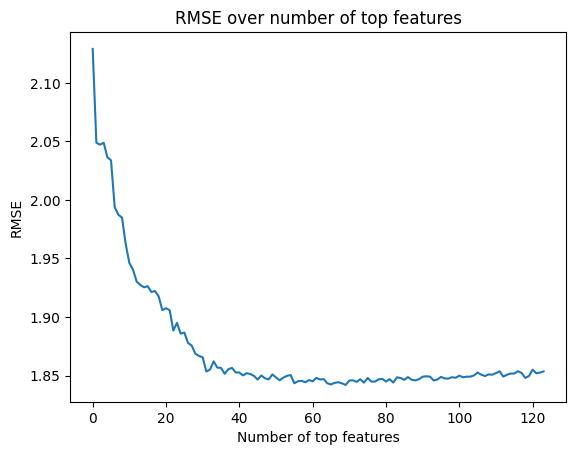

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(rmses.values())
plt.title('RMSE over number of top features')
plt.xlabel('Number of top features')
plt.ylabel('RMSE')
plt.show()

In [9]:
# Find the key with the minimum value
min_key = min(rmses, key=rmses.get)

print("Index with the minimum value:", min_key)
print("Minimum value:", rmses[min_key])

Index with the minimum value: 70
Minimum value: 1.8419795763656581
